In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
import shap

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [9]:
# Create a custom dataset class for brain tumor images
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert numpy array to PIL Image
        image = Image.fromarray(image.squeeze().astype(np.uint8))
        
        if self.transform:
            image = self.transform(image)
            
        return image, label


In [10]:
# Function to load and prepare image data
def load_image_data(data_dir, image_size=128, batch_size=500, verbose=True):
    all_images = []
    all_labels = []
    class_counts = {0: 0, 1: 0}
    
    # Get file paths
    glioma_images = [os.path.join(data_dir, 'glioma', f) for f in os.listdir(os.path.join(data_dir, 'glioma')) 
                    if f.endswith(('.jpg', '.png', '.jpeg'))]
    notumor_images = [os.path.join(data_dir, 'notumor', f) for f in os.listdir(os.path.join(data_dir, 'notumor')) 
                     if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    all_files = glioma_images + notumor_images
    total_images = len(all_files)
    print(f"Total images found: {total_images}")
    
    if total_images == 0:
        print("No image files found in the directory.")
        return None, None, None, None

    # Process images in batches
    for batch_start in range(0, total_images, batch_size):
        batch_end = min(batch_start + batch_size, total_images)
        
        if verbose:
            print(f"Loading batch {batch_start}-{batch_end} out of {total_images}")
        
        batch_images = []
        batch_labels = []
        
        for i in range(batch_start, batch_end):
            try:
                file_path = all_files[i]
                
                # Load and process image
                img = Image.open(file_path).convert('L')  # Convert to grayscale
                img = img.resize((image_size, image_size))
                img_array = np.array(img)
                img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
                
                # Set label based on file path
                label = 1 if 'glioma' in file_path else 0
                
                batch_images.append(img_array)
                batch_labels.append(label)
                class_counts[label] += 1
            
            except Exception as e:
                print(f"Error processing file {i} ({file_path}): {str(e)}")
        
        all_images.extend(batch_images)
        all_labels.extend(batch_labels)
        gc.collect()
    
    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels).astype(np.float32)
    
    if verbose:
        print(f"Data loading complete. Total samples: {len(X)}")
        print(f"Class distribution: Class 0: {class_counts[0]}, Class 1: {class_counts[1]}")
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    del X, y
    gc.collect()
    
    return X_train, X_test, y_train, y_test


In [11]:
# Define the CNN model for brain tumor classification
class BrainTumorModel(nn.Module):
    def __init__(self):
        super(BrainTumorModel, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 16 * 64, 64)  # For 128x128 input, after 3 pooling layers
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x


In [12]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=3):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().view(-1, 1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)
        
        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}')
    
    return history


In [13]:
#  Main function to run the classification pipeline
def run_binary_image_classification(data_dir, image_size=128, batch_size=16, epochs=100):
    print("\n===== Step 1: Loading Image Data =====")
    X_train, X_test, y_train, y_test = load_image_data(data_dir, image_size=image_size)
    
    if X_train is None:
        print("No data loaded. Please check the dataset path.")
        return None, None, None, None

    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Create datasets
    train_dataset = BrainTumorDataset(X_train, y_train, transform=transform)
    test_dataset = BrainTumorDataset(X_test, y_test, transform=transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print("\n===== Step 2: Creating Binary Classification Model =====")
    model = BrainTumorModel().to(device)
    print(model)
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print("\n===== Step 3: Training Binary Classification Model =====")
    history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs)
    
    return model, history, X_train, X_test, y_train, y_test, train_dataset, test_dataset


In [14]:
# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [15]:
# SHAP Explainer wrapper for PyTorch model
class ShapExplainer:
    def __init__(self, model, background_data=None, n_background=100):
        self.model = model
        self.model.eval()
        
        if background_data is not None:
            if isinstance(background_data, DataLoader):
                background = []
                count = 0
                for x, _ in background_data:
                    background.append(x)
                    count += x.shape[0]
                    if count >= n_background:
                        break
                background = torch.cat(background, dim=0)[:n_background]
            else:
                background = background_data[:n_background]
                
            background = background.to(next(model.parameters()).device)
            print(f"Creating DeepExplainer with {len(background)} background samples")
            self.explainer = shap.DeepExplainer(model, background)
        else:
            print("No background data provided. Will use GradientExplainer.")
            self.explainer = None
    
    def explain_images(self, images, return_type="shap_values"):
        images = images.to(next(self.model.parameters()).device)
        
        if self.explainer is None:
            self.explainer = shap.GradientExplainer(self.model, images)
        
        shap_values = self.explainer.shap_values(images)
        
        if return_type == "shap_values":
            return shap_values
        elif return_type == "visualization":
            if isinstance(shap_values, list) and len(shap_values) == 1:
                shap_values = shap_values[0]
            
            if isinstance(shap_values, torch.Tensor):
                shap_values = shap_values.cpu().numpy()
            
            if isinstance(images, torch.Tensor):
                images = images.cpu().numpy()
            
            return shap_values
        else:
            raise ValueError(f"Invalid return_type: {return_type}")


In [16]:
#  Function to create SHAP summary plot
def shap_summary_plot(model, test_dataset, num_examples=50):
    print("\n===== SHAP Summary Plot =====")
    
    test_loader = DataLoader(test_dataset, batch_size=num_examples, shuffle=True)
    images, labels = next(iter(test_loader))
    
    background_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)
    shap_explainer = ShapExplainer(model, background_loader, n_background=50)
    
    shap_values = shap_explainer.explain_images(images)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    
    if isinstance(shap_values, torch.Tensor):
        shap_values = shap_values.cpu().numpy()
    if isinstance(images, torch.Tensor):
        images = images.cpu().numpy()
    
    shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)
    images_reshaped = images.reshape(images.shape[0], -1)
    
    shap.summary_plot(
        shap_values_reshaped, 
        images_reshaped,
        feature_names=[f"Pixel {i}" for i in range(shap_values_reshaped.shape[1])],
        max_display=20,
        plot_type="bar"
    )


In [17]:
# Function to analyze SHAP values by class
def analyze_shap_by_class(model, test_dataset, num_examples=50):
    print("\n===== SHAP Analysis by Class =====")
    
    test_loader = DataLoader(test_dataset, batch_size=num_examples, shuffle=True)
    images, labels = next(iter(test_loader))
    
    background_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)
    shap_explainer = ShapExplainer(model, background_loader, n_background=50)
    
    shap_values = shap_explainer.explain_images(images)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    
    if isinstance(shap_values, torch.Tensor):
        shap_values = shap_values.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    
    # Separate by class
    glioma_indices = np.where(labels == 1)[0]
    notumor_indices = np.where(labels == 0)[0]
    
    glioma_shap = shap_values[glioma_indices]
    notumor_shap = shap_values[notumor_indices]
    
    # Average SHAP values
    glioma_avg_shap = np.mean(np.abs(glioma_shap), axis=0)
    notumor_avg_shap = np.mean(np.abs(notumor_shap), axis=0)
    
    # Visualize
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.imshow(glioma_avg_shap.squeeze(), cmap='hot')
    plt.title("Average SHAP Magnitude - Glioma Class")
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(notumor_avg_shap.squeeze(), cmap='hot')
    plt.title("Average SHAP Magnitude - No Tumor Class")
    plt.colorbar()
    plt.axis('off')
    
    diff_shap = glioma_avg_shap - notumor_avg_shap
    plt.subplot(2, 2, 3)
    plt.imshow(diff_shap.squeeze(), cmap='RdBu_r')
    plt.title("SHAP Difference (Glioma - No Tumor)")
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.hist(diff_shap.flatten(), bins=50)
    plt.title("Distribution of SHAP Differences")
    plt.xlabel("SHAP Value Difference")
    plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()



===== Step 1: Loading Image Data =====
Total images found: 705
Loading batch 0-500 out of 705
Loading batch 500-705 out of 705
Data loading complete. Total samples: 705
Class distribution: Class 0: 405, Class 1: 300

===== Step 2: Creating Binary Classification Model =====
BrainTumorModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (

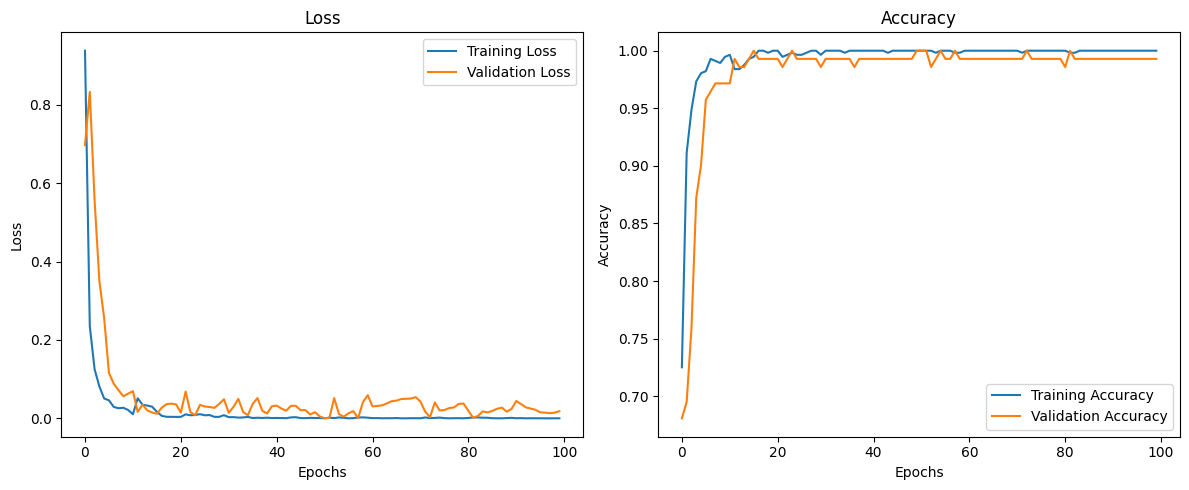


===== SHAP Explanations =====
Creating DeepExplainer with 50 background samples


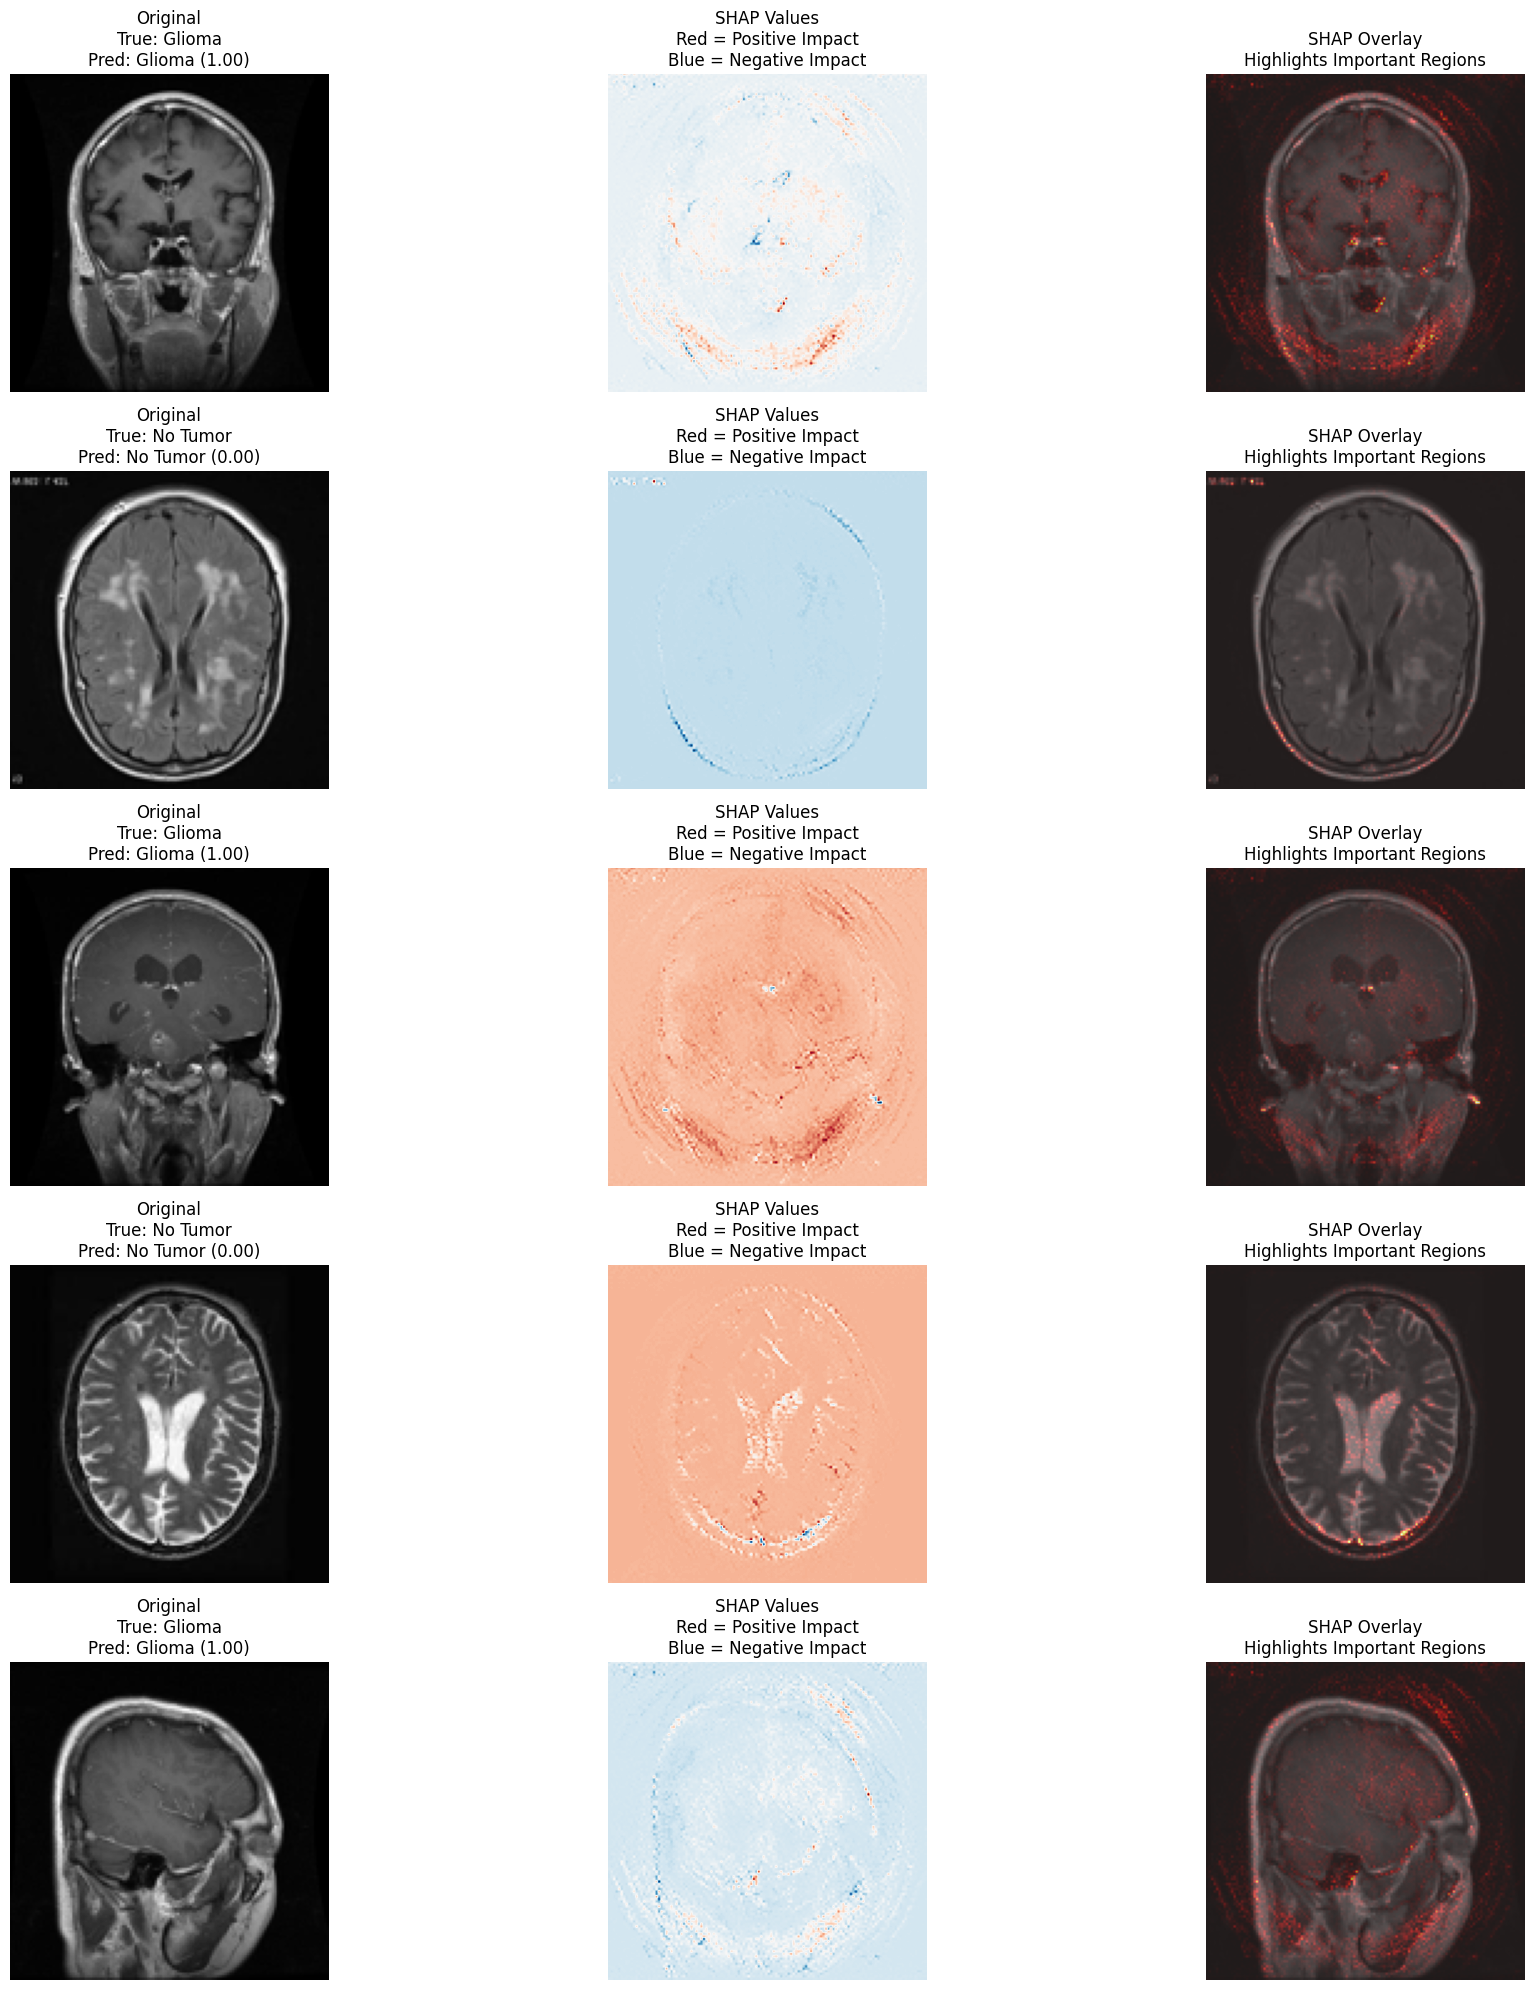


===== SHAP Summary Plot =====
Creating DeepExplainer with 50 background samples


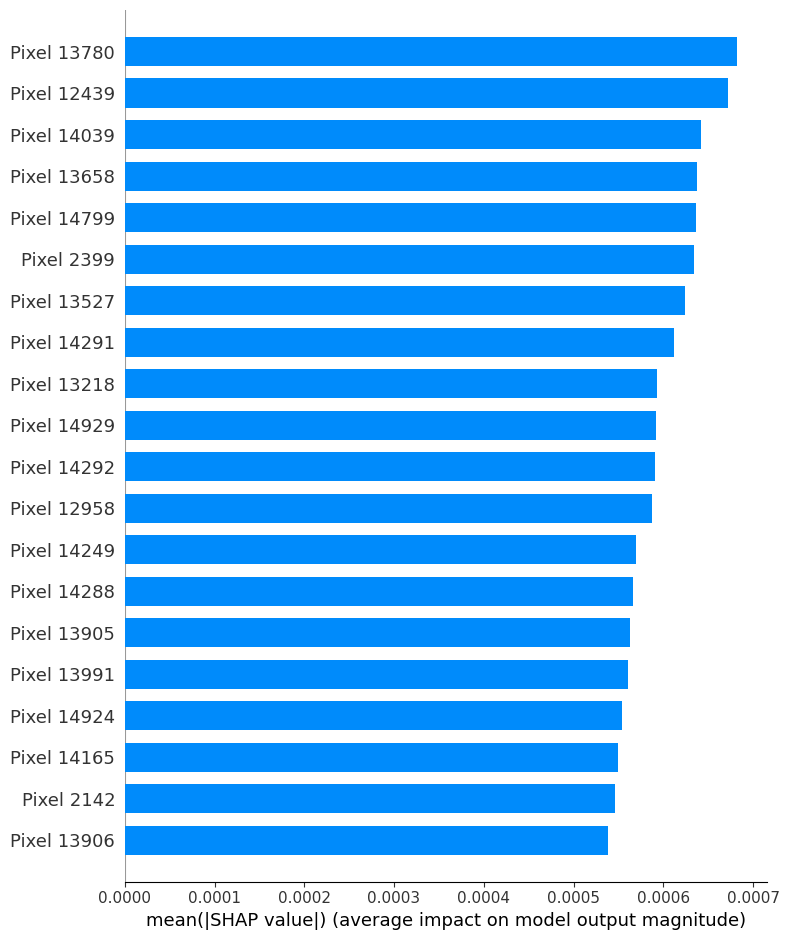


===== SHAP Analysis by Class =====
Creating DeepExplainer with 50 background samples


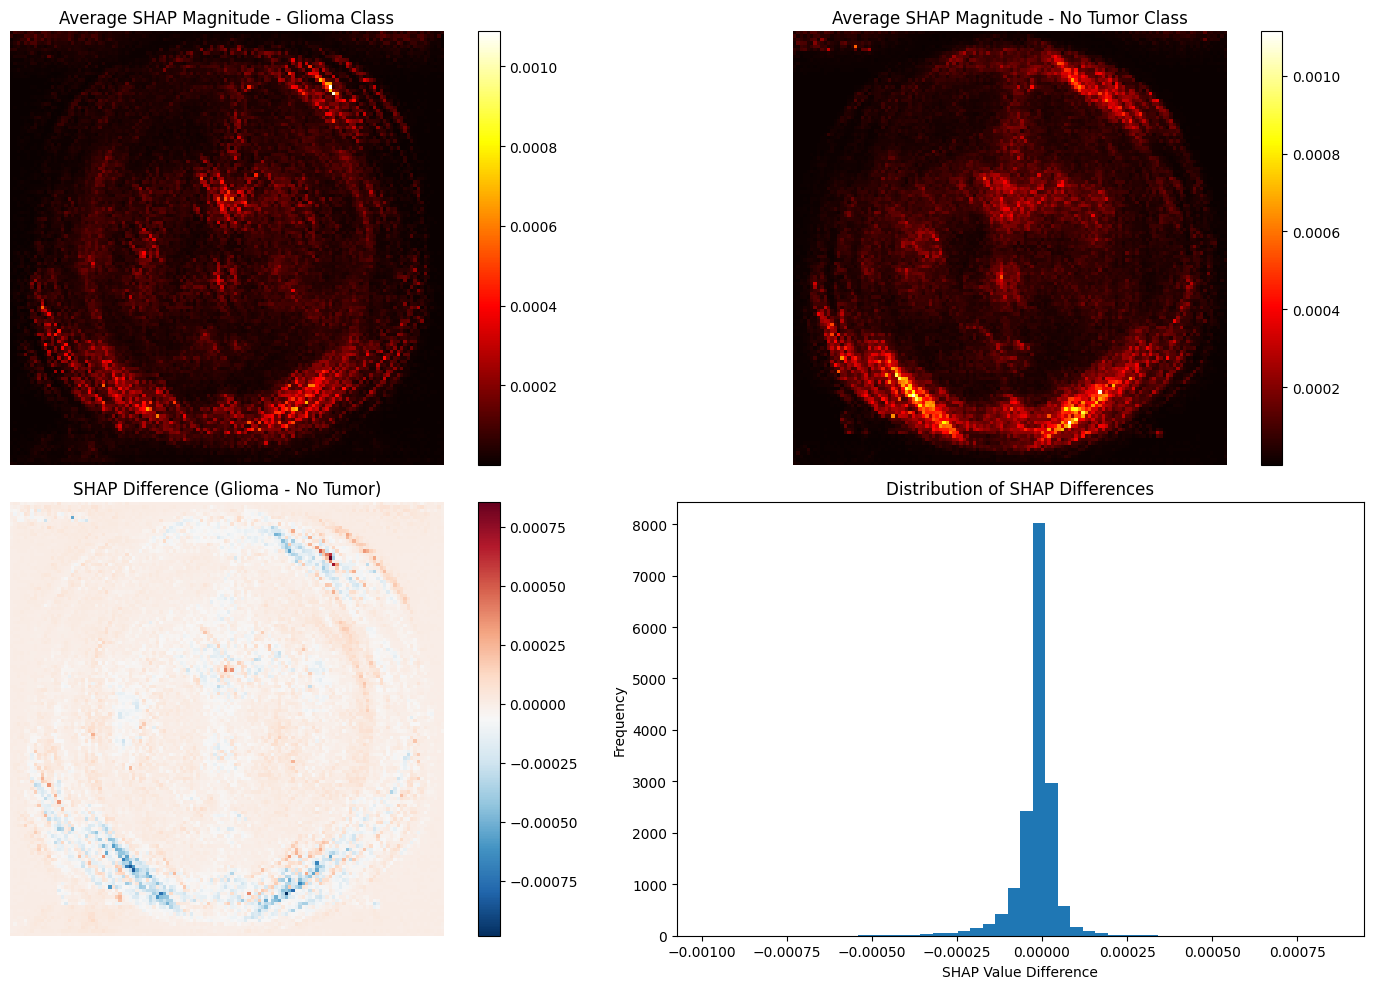

In [18]:
# Main execution
if __name__ == "__main__":
    # Set your data directory
    data_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"
    
    # Run the training pipeline
    model, history, X_train, X_test, y_train, y_test, train_dataset, test_dataset = run_binary_image_classification(
        data_dir, image_size=128, batch_size=64, epochs=100
    )
    
    # Plot training history
    plot_training_history(history)
    
    # SHAP visualizations
    visualize_shap_explanations(model, test_dataset, num_examples=5)
    shap_summary_plot(model, test_dataset, num_examples=50)
    analyze_shap_by_class(model, test_dataset, num_examples=50)
